In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, dendrogram

num_clusters = 6
train_count = 10000
plotted_point_count = 500

ЗАПИСЫВАЕМ ДАННЫЕ В ТАБЛИЦЫ

In [16]:
import sqlite3
dfStr = pd.read_csv('checks_str.txt', sep='\t')   #Читаем чеки
dfTitles = pd.read_csv('checks_titles.txt', sep='\t')   #Читаем доп.инфу по каждому чеку
names = pd.read_csv('id.txt', sep='\t', names=['idtov','name'])  #Читаем ID каждого товара
data = pd.merge(dfStr, names, on='idtov') #Объединение чеков с именами товаров 

data = pd.merge(dfTitles, data, on='iddoc') # Объединение чеков с доп.инф по ним
print(data.head())

   iddoc             docdate  return store  kassa seller collector idtov  \
0  227FR  2017-01-0308:14:07       0     N      1      H        2O   92N   
1  227FU  2017-01-0308:14:08       0     N      1     3U        39   7P9   
2  227FV  2017-01-0308:14:09       0     N      1     2O        39   38O   
3  227FW  2017-01-0308:14:10       0     N      1     3U        39   9O0   
4  227FX  2017-01-0308:14:11       0     N      1     2O        39   DJZ   

   count  price   summa                                               name  
0    4.0   68.0   272.0  Батарейка Duracell Turbo LR 6 2BL             ...  
1    2.0    7.5    15.0  Подрозетник СЗМ3 д/бетон. стен                ...  
2    1.0   48.0    48.0  Батарейка Duracell LR03 бл/2 81268853         ...  
3    1.0   11.0    11.0  Подрозетник 68*47 д/полых стен PE 030 040     ...  
4    8.0  182.0  1456.0  Лампа экон. Camelion LH 20W E14 4200К LH-FS-T2...  


In [3]:
group_by_iddoc = data.groupby(['iddoc'])
ch = group_by_iddoc.sum() 
ch['count_uniq_good'] = group_by_iddoc.size()
ch  # ch - информация о каждом чеке (общая сумма, кол-во товаров и т.д)

C:\Users\kasae\AppData\Local\Temp\ipykernel_14096\4056925311.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ch = group_by_iddoc.sum()


,return,kassa,count,price,summa,count_uniq_good
iddoc,,,,,,
227FR,0,1,4.0,68.0,272.0,1
227FU,0,1,2.0,7.5,15.0,1
227FV,0,1,1.0,48.0,48.0,1
227FW,0,1,1.0,11.0,11.0,1
227FX,0,1,8.0,182.0,1456.0,1
...,...,...,...,...,...,...
2K3WT,0,7,2.0,39.0,78.0,1
2K3WU,0,21,14.0,554.0,1391.0,3
2K3WV,0,7,5.0,145.0,652.5,1


## K-means кластеризация

In [4]:
checks = ch.drop(columns=["return", "kassa", "price"])    #Удаляем поля
checks = checks[checks['count_uniq_good'] > 2]   #Используем только чеки с  >=  3 товарами
checks = checks[checks['summa'] > 0]   #Используем только чеки с суммой  >  0
checks.head()   #93920 results

,count,summa,count_uniq_good
iddoc,,,
227G1,10.0,38.60,3
227G9,3.0,233.00,3
227GA,44.0,2734.20,5
227GB,432.0,7506.00,20
227GG,3.0,1260.15,3


In [5]:


from sklearn import preprocessing

#cheks - чеки у которых больше 3-ех позиций и сумма больше 0
#нормализация данных
print(checks)
checks = pd.DataFrame(preprocessing.normalize(checks, axis=0), index = checks.index.values) #Приводим все в числа от 0 до 1
 
checks.columns=["kolvo","summa","count_uniq_good"]

trainDF = pd.DataFrame(checks[:train_count])  #Обрезаем нашу таблицу до 10000 чеков 
# trainDF - таблица, которую мы используем для тренировки ИИ

train = trainDF.values # Достаем только значения


       count    summa  count_uniq_good
iddoc                                 
227G1   10.0    38.60                3
227G9    3.0   233.00                3
227GA   44.0  2734.20                5
227GB  432.0  7506.00               20
227GG    3.0  1260.15                3
...      ...      ...              ...
2K3VS    7.0   383.00                3
2K3W7    5.0   342.00                3
2K3W8    4.0   421.00                3
2K3WU   14.0  1391.00                3
2K3WZ    4.0   596.00                3

[93920 rows x 3 columns]


In [6]:

#описываем модель
model = KMeans(n_clusters = num_clusters)

#Тренируем ИИ
model.fit(train)   

#Список того, к какой группе кластеров(групп, кол-во которых мы задали в num_clusters) принадлежит каждая строка из trainDF
#Мы можем сделать теперь это с любым объектом базы данных, и model.predict(object) скажет, к какому кластеру он относится
all_predictions = model.predict(train)

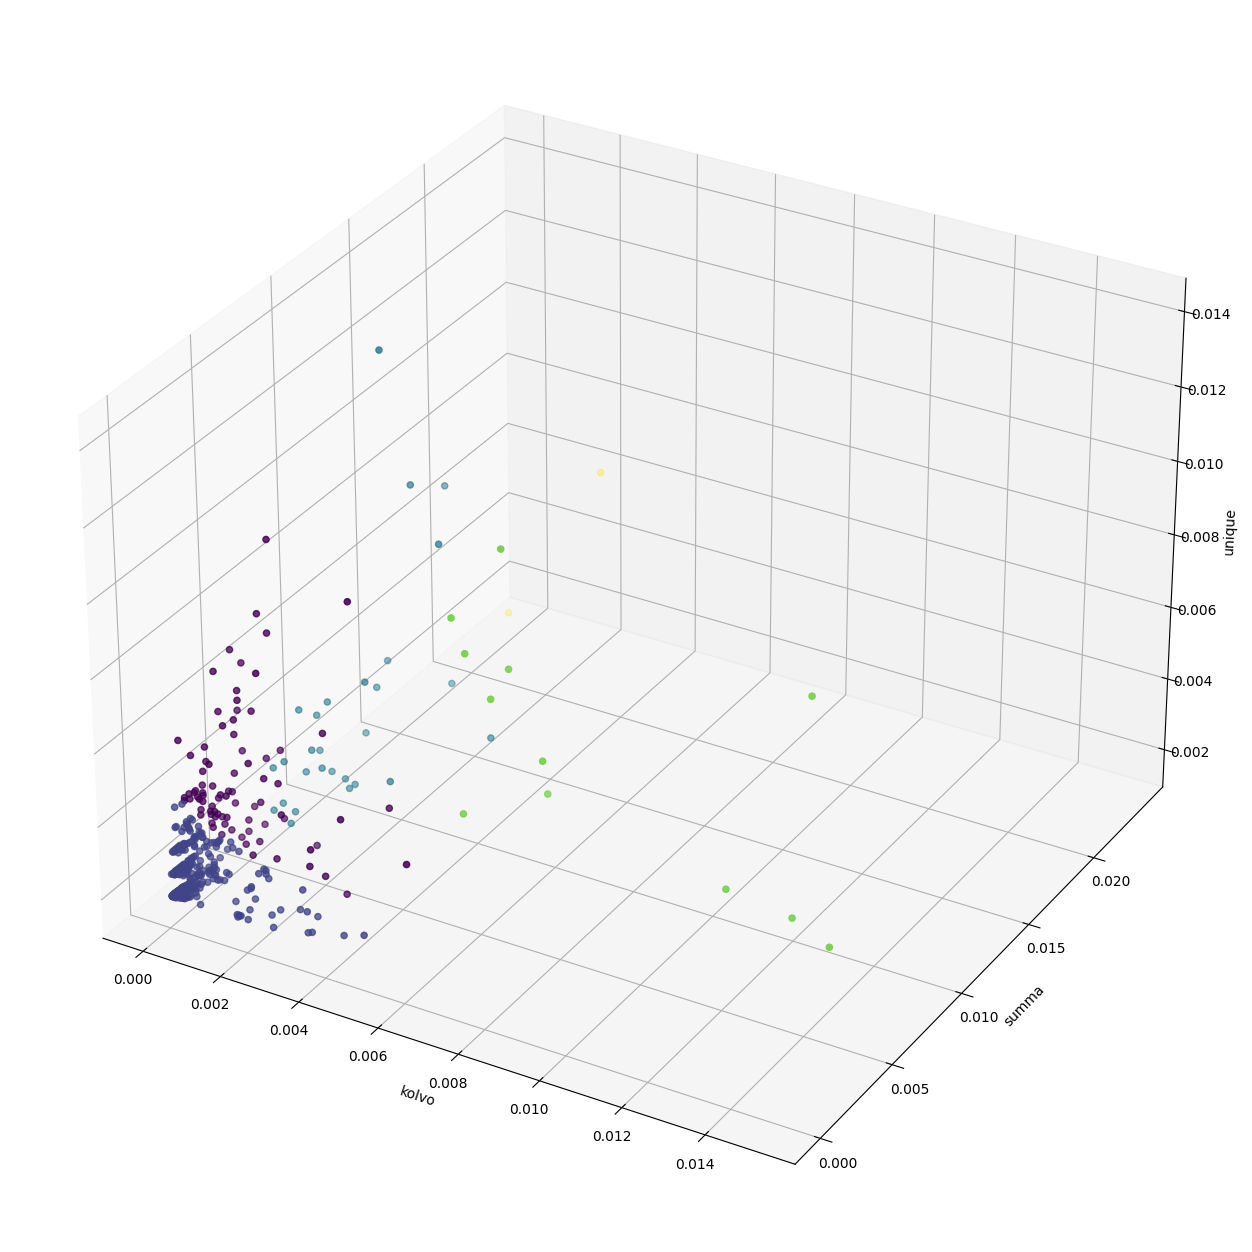

In [7]:
x_axis = train[:plotted_point_count, 0]   #Поля 'kolvo' во всех элемнетах спиаска train 
y_axis = train[:plotted_point_count, 1]
z_axis = train[:plotted_point_count, 2]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(xlabel="kolvo")
ax.set_ylabel(ylabel="summa")
ax.set_zlabel(zlabel="unique")
ax.scatter(x_axis, y_axis, z_axis, c=all_predictions[:plotted_point_count])

## Иерархическая кластеризация

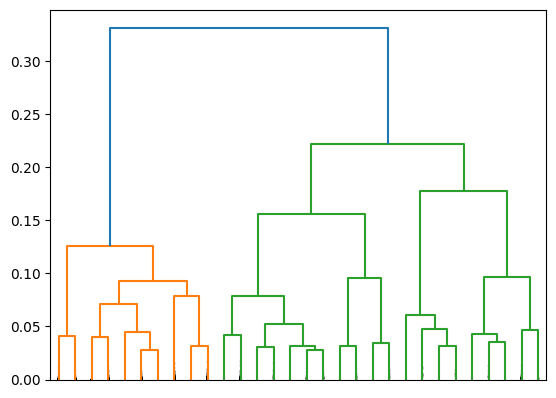

In [8]:
#сгенерировать матрицу связей

#проводим моделирование
mergings = linkage(train, method='ward') #Считает расс-ие между кластерами

#Выводим дендограму для анализа данных
dendrogram(mergings,
           truncate_mode='lastp',
           show_leaf_counts=False,
           leaf_rotation=90,
           leaf_font_size=12,
          show_contracted=True,)

plt.show()

In [9]:
mergings

array([[6.67400000e+03, 8.80500000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.50000000e+01, 8.37000000e+02, 0.00000000e+00, 2.00000000e+00],
       [3.40000000e+01, 2.98900000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.99870000e+04, 1.99930000e+04, 1.77966856e-01, 2.95000000e+02],
       [1.99950000e+04, 1.99960000e+04, 2.22157239e-01, 8.19000000e+02],
       [1.99940000e+04, 1.99970000e+04, 3.31527192e-01, 1.00000000e+04]])

## Метод кластеризации на основе плотности DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

# Определяем модель
dbscan = DBSCAN(eps=0.0005, min_samples=100) #Радиус и миним. кол-во точек в радиусе
 
# Обучаем
dbscan.fit(trainDF)


all_predictions = dbscan.labels_


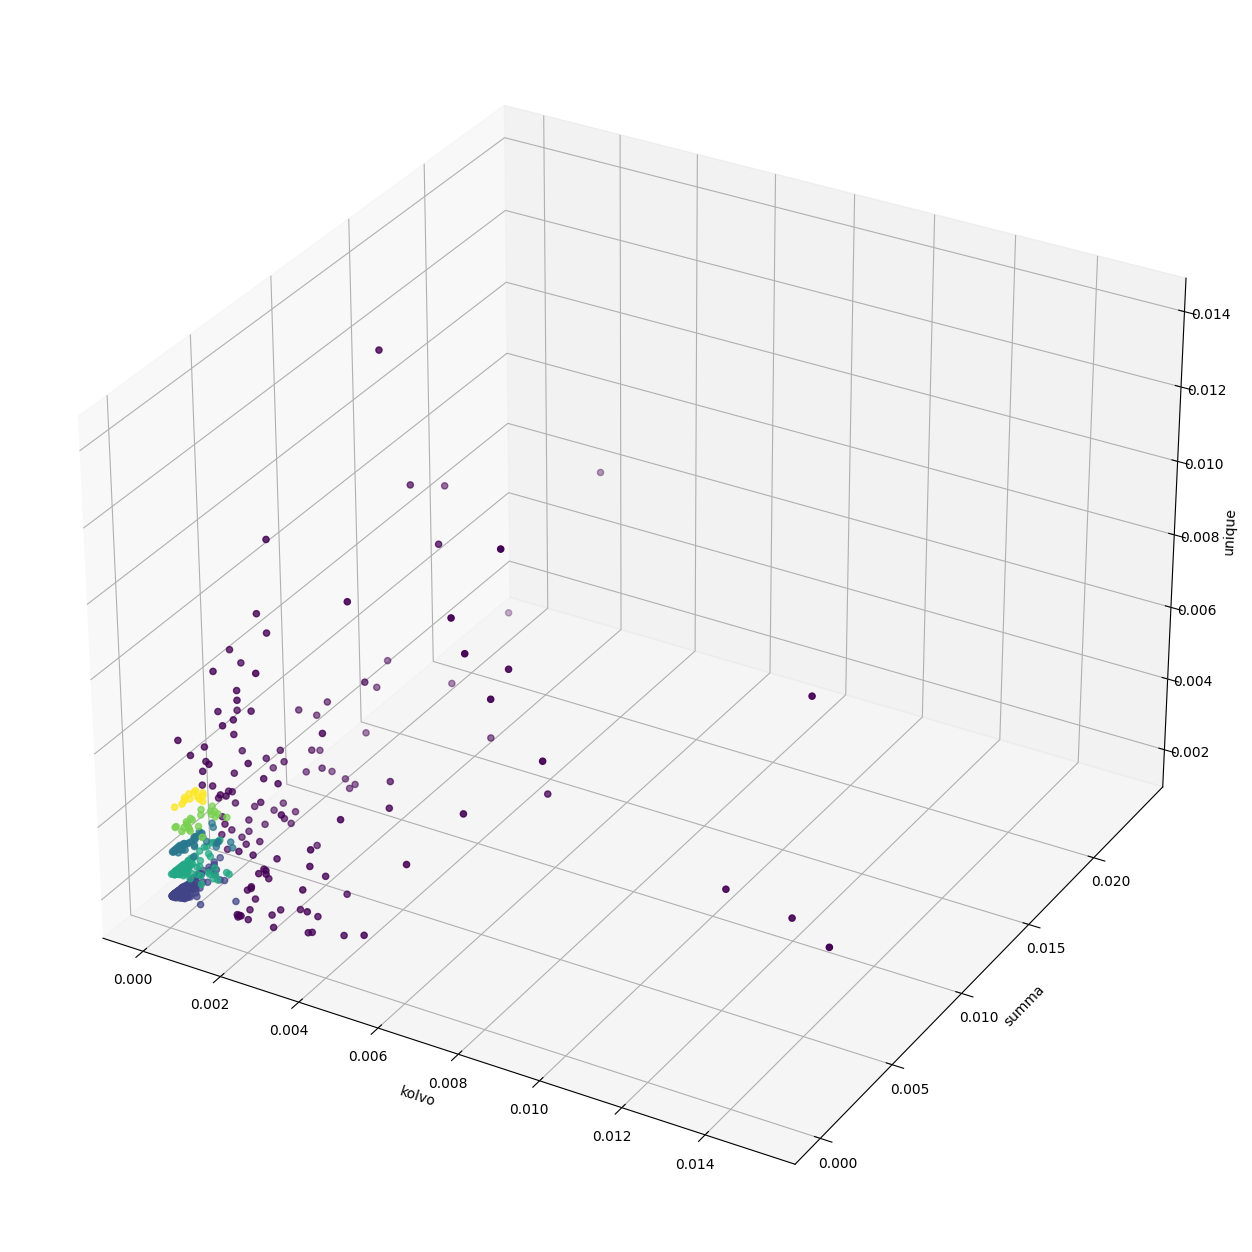

In [11]:
x_axis = train[:plotted_point_count, 0]
y_axis = train[:plotted_point_count, 1]
z_axis = train[:plotted_point_count, 2]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(xlabel="kolvo")
ax.set_ylabel(ylabel="summa")
ax.set_zlabel(zlabel="unique")
ax.scatter(x_axis, y_axis, z_axis, c=all_predictions[:plotted_point_count])


ТЕСТОВАЯ ПРОВЕРКА

In [12]:
dfrm = pd.Series({'predicted':all_predictions})  
trainDF['predicted'] = dfrm['predicted']    #Записываем для каждого элемента его кластер
trainDF

,kolvo,summa,count_uniq_good,predicted
227G1,0.000165,0.000019,0.001825,0
227G9,0.000050,0.000113,0.001825,0
227GA,0.000727,0.001326,0.003042,1
227GB,0.007139,0.003640,0.012168,-1
227GG,0.000050,0.000611,0.001825,0
...,...,...,...,...
240QT,0.000859,0.001019,0.001825,0
240QV,0.000083,0.000565,0.002434,2
240RE,0.001256,0.003481,0.001825,-1
240RL,0.000099,0.000053,0.001825,0


In [13]:
#Тест
import recommendation
testCheck = pd.DataFrame(checks[train_count+10:train_count+11]) #Берем 1 элемент для проверки
# print(testCheck)
pred = model.predict(testCheck.values) #Прогоняем через обученную модель на основе K-means и получаем номер кластера

req = recommendation.Recommendation().get_recommendations(testCheck)
print(testCheck)


          kolvo     summa  count_uniq_good
240T5  0.008858  0.003202         0.006084


In [14]:
a = []

for index, t in testCheck.iterrows():

    closest = model.predict(np.array([t.values])) #получаем номер кластера тестового чека
    similar_checks = pd.DataFrame(trainDF[trainDF['predicted']==closest[0]]) #Все чеки с таким же кластером
    check_content = pd.DataFrame(data[data["iddoc"]==index]) #Все товары тестового чека
    
    #получить все товары из чеков с таким же кластером
    train_tov = pd.DataFrame(data[data['iddoc'].isin(similar_checks.index.values)])

    
    for check_index, tovar in check_content.iterrows():
        #отбираем все товары (из чеков с таким же кластером) у которых есть товары, как в тестовом чеке
        a.append(train_tov[train_tov['idtov'] == tovar['idtov']])
        
    a = pd.concat(a) #Создаем таблицу
    
    #Группируем из отдельных товаров в один чек (чек  -  кол-во товаров)
    a = pd.DataFrame(a.groupby(['iddoc']).size().reset_index(name='count')) 
    a = a.sort_values(by=['count', 'iddoc'], ascending=False) # Сортируем
    # a - Таблица:  Чек  -  кол-во товаров в чеке 


    b = []
    for ind, k in a.iterrows():    #(76 эл.)
        t = pd.DataFrame(data[data["iddoc"]==a.loc[ind]['iddoc']])  #Как train_tov, но там мы берем только некоторые товары, а здесь все
        b.extend(t.values) 
    #b - как a, но берем не только те товары из чека, которые есть в тестовом чеке, а  все товары с этого чека

    b = pd.DataFrame(b, columns = data.columns)
    summ = b.groupby(['idtov']).sum(numeric_only=True)    #Общая суммированная информация о каждом товаре
    summ['count_good'] = b.groupby(['idtov']).size()  #Добавление поля кол-ва товаров 
    summ = summ.sort_values(by = ['count_good'], ascending=False)  #Сортируем по кол-ву товаров
summ = pd.merge(summ, names, on='idtov')
# summ - сгруппированная(по idtov) суммированная информация о товарарах, которые мы отобрали из чеков(data), в которых есть товары из тестового чека

In [15]:
for index, tov in check_content.iterrows():
    summ = summ[summ.idtov != tov.idtov]   #удаляем тестовые товары из summ
summ = summ.sort_values(by = ['count_good'], ascending=False)
summ.head(15)

,idtov,return,kassa,count,price,summa,count_good,name
3,6O6,0,20,6.0,160.0,240.00,4,Изолента ПВХ REXANT цветная 19*25мм 09-2206 ...
5,7P9,0,21,9.0,23.0,70.00,3,Подрозетник СЗМ3 д/бетон. стен ...
4,2CZ,0,13,4.0,2258.0,2906.44,3,Эл.счетчик Меркурий 201.5 (5-60А) 1-фазный ...
11,RD,0,2,14.0,24.0,168.00,2,"Подрозетник СЗЕ2, СЗЕ3 д/г.к. стен ..."
13,A2U,0,6,30.0,1.6,24.00,2,Дюбель шуруп. потай 6*40 Омах 25300604 ...
12,9J,0,8,10.0,178.0,863.30,2,Автом.выкл. ИЭК ВА 47- 29 1р 20А ...
14,41L,0,2,2.0,110.0,104.50,2,Шина нулевая PEN 6*9 ( 8/2) ИЭК ...
10,9F,0,8,2.0,177.0,177.00,2,Автом.выкл. ИЭК ВА 47- 29 1р 10А ...
8,I9S,0,6,4.0,216.0,410.40,2,"Зажим ответвительный ЗОИ 16-70/1,5-10 IEK ..."
7,KY,0,14,39.0,59.0,1150.50,2,"Кабель ВВГп 2* 2,5 ..."
